**OBJECTIVE:** Assess the feasibility of building a VIMuRe model using OECD data.



**Import libraries**

In [1]:
%matplotlib inline

In [2]:
import openpyxl
import pandas as pd
import vimure as vm

# 1. The data

## 1.1 How to download the data

1. Head to OECD Stats and look for the [Balanced International Trade in Services (2005-2021)](https://stats.oecd.org/Index.aspx?DataSetCode=BATIS_EBOPS2010) data set
2. Click 'Export' then 'Related files' and click on 'Bulk download' to download a file called `OECD-WTO_BATIS_BPM6_April2023_bulk.zip`
3. Unpack the zip file to and move the unpacked files to your `data` folder. You will find two files:
    - `OECD-WTO_BATIS_BPM6_April2023_bulk.csv` (1.32 GB)
    - `OECD-WTO_BATIS_BPM6_April2023_codes.xlsx` (32 KB)

In [3]:
# Set the folder where the data is stored
DATA_FOLDER = '../../data/OECD'

batis_data_filename  = f'{DATA_FOLDER}/OECD-WTO_BATIS_BPM6_April2023_bulk.csv'

## 1.2 First contacts with the data

In [4]:
batis_df = pd.read_csv(batis_data_filename)
batis_df

,Reporter,type_Reporter,Partner,type_Partner,Flow,Item_code,type_Item,Year,Reported_value,Final_value,Methodology,Balanced_value
0,ABW,c,AFG,c,EXP,S,s,2005,NaN,0.193868,M1.3,0.098872
1,ABW,c,AFG,c,IMP,S,s,2005,NaN,0.092933,M1.4,0.069085
2,ABW,c,AFG,c,EXP,S,s,2006,NaN,0.196892,M1.3,0.104561
3,ABW,c,AFG,c,IMP,S,s,2006,NaN,0.099563,M1.4,0.074507
4,ABW,c,AFG,c,EXP,S,s,2007,NaN,0.230675,M1.3,0.116994
...,...,...,...,...,...,...,...,...,...,...,...,...
23941333,ZWE,c,ZMB,c,EXP,SPX4,d,2019,NaN,0.000000,A,0.040000
23941334,ZWE,c,ZMB,c,IMP,SPX4,d,2020,NaN,0.030000,A,0.000200
23941335,ZWE,c,ZMB,c,EXP,SPX4,d,2020,NaN,0.000000,A,0.060000
23941336,ZWE,c,ZMB,c,IMP,SPX4,d,2021,NaN,0.040000,A,0.000200


# 2. Data cleaning decisions

**The original data looks like this:**

In [5]:
batis_df.head()

,Reporter,type_Reporter,Partner,type_Partner,Flow,Item_code,type_Item,Year,Reported_value,Final_value,Methodology,Balanced_value
0,ABW,c,AFG,c,EXP,S,s,2005,NaN,0.193868,M1.3,0.098872
1,ABW,c,AFG,c,IMP,S,s,2005,NaN,0.092933,M1.4,0.069085
2,ABW,c,AFG,c,EXP,S,s,2006,NaN,0.196892,M1.3,0.104561
3,ABW,c,AFG,c,IMP,S,s,2006,NaN,0.099563,M1.4,0.074507
4,ABW,c,AFG,c,EXP,S,s,2007,NaN,0.230675,M1.3,0.116994


## Restrict to countries, instead of groups of countries:

In [6]:
batis_df.query('type_Reporter == "c" and type_Partner == "c"', inplace=True)

## Restrict to standard BPM6 service item (and discard derived items):

In [7]:
batis_df.type_Item.value_counts()

s    18035368
d     5549344
Name: type_Item, dtype: int64

In [8]:
batis_df.query('type_Item == "s"', inplace=True)

## Don't do anything with the Methodology column:

In [9]:
# It's very diverse
batis_df['Methodology'].value_counts()

M2.1       5347177
M2.2       4119471
W0         3124021
M8.2        778979
E0          755657
M2.3        673226
R_EURO      508308
Z           458848
E8.2        362009
M1.1        352781
M2.0        326951
M1.3        248527
M1.4        178787
E8.0        177077
M1.2        137815
R_OECD      118822
M8.3         78736
R_NAT.1      77005
E8.1         58544
R_NAT        56129
R_EUEQ       45624
M1.5         23912
M8.0         16094
E1            5896
R_UNSD        4382
E6             590
Name: Methodology, dtype: int64

# 3. Data Preprocessing

Get the data in the format we want for VIMuRe.

Focus on just the columns we need:

In [10]:
selected_cols = ['Reporter', 'Partner', 'Flow', 'Year', 'Final_value']
drop_cols = [col for col in batis_df.columns if col not in selected_cols]

batis_df.drop(columns=drop_cols, inplace=True)

Split the data frame into exports and imports so we can efficiently assign `ego` and `alter` columns in the format [required by VIMuRe](https://latentnetworks.github.io/vimure/latest/tutorials/R/tutorial01-data-preparation.html):

In [11]:
exp_df = batis_df[batis_df['Flow'] == 'EXP']
imp_df = batis_df[batis_df['Flow'] == 'IMP']

In [12]:
common_cols_mapping = {
    'Reporter': 'reporter',
    'Flow': 'tie_type',
    'Final_value': 'weight',
    'Year': 'year'
}

exp_df = (exp_df.rename(columns=common_cols_mapping)
                .assign(ego=lambda x: x['reporter'])
                .rename(columns={'Partner': 'alter'})
                .copy())
imp_df = (imp_df.rename(columns=common_cols_mapping)
                .assign(alter=lambda x: x['reporter'])
                .rename(columns={'Partner': 'ego'})
                .copy())

Recreate `batis_df`:

In [13]:
batis_df = pd.concat([exp_df, imp_df], ignore_index=True)
batis_df['layer'] = 'trade'
del exp_df, imp_df

Put data frame in the same order present in the tutorials:

In [14]:
cols_order = ['ego', 'alter', 'reporter', 'tie_type', 'layer', 'weight', 'year']

batis_df = batis_df[cols_order].copy()
batis_df.head()


,ego,alter,reporter,tie_type,layer,weight,year
0,ABW,AFG,ABW,EXP,trade,0.193868,2005
1,ABW,AFG,ABW,EXP,trade,0.196892,2006
2,ABW,AFG,ABW,EXP,trade,0.230675,2007
3,ABW,AFG,ABW,EXP,trade,0.264227,2008
4,ABW,AFG,ABW,EXP,trade,0.280256,2009


# 3. High-level analysis

## 3.1 Summary Statistics

In [15]:
all_countries = set(batis_df['ego'].unique()).union(set(batis_df['alter'].unique()))
all_reporters = set(batis_df['reporter'].unique())

In [16]:
print(f"In total, there are {len(all_countries)} countries in the dataset, of which {len(all_reporters)} are reporters.")

In total, there are 203 countries in the dataset, of which 202 are reporters.


What are the countries that do not feature as reporters in the data set?

In [17]:
all_countries.difference(all_reporters)

{'RWD'}

From the data dictionary, we get that:

| **Code**   | **Description**           |
|------------|---------------------------|
| E_EU	     | Extra-EU trade            |
| NOC        | Non-OECD member economies |
| RWD        | Rest of the world         |

## 3.2 Simple plots

<Axes: title={'center': 'Total trade flows by year and type of trade'}, xlabel='year'>

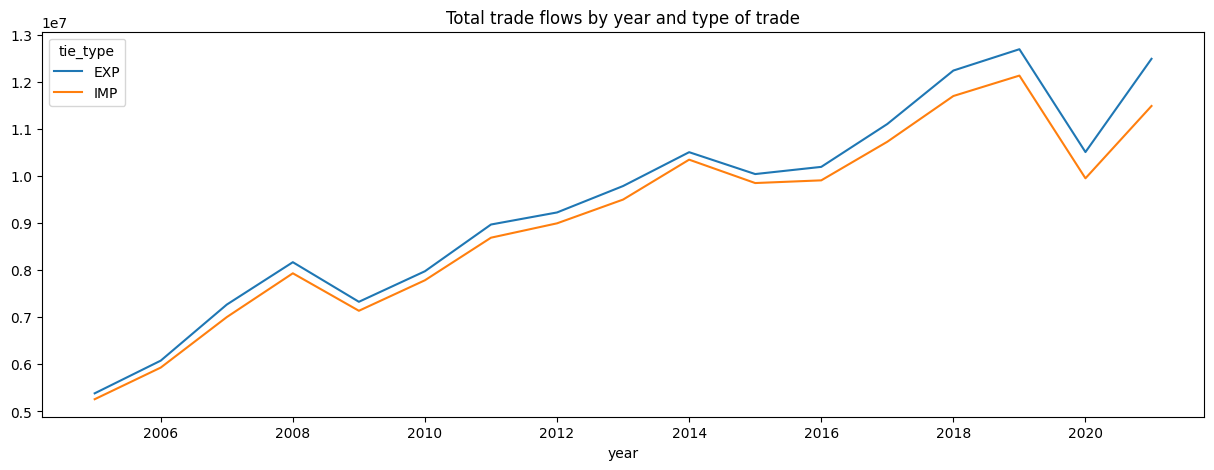

In [18]:
(batis_df.groupby(['year', 'tie_type'])['weight'].sum().unstack()
         .plot(figsize=(15, 5), title='Total trade flows by year and type of trade'))

<Axes: title={'center': 'The number of countries reporting trade flows over time is constant'}, xlabel='year'>

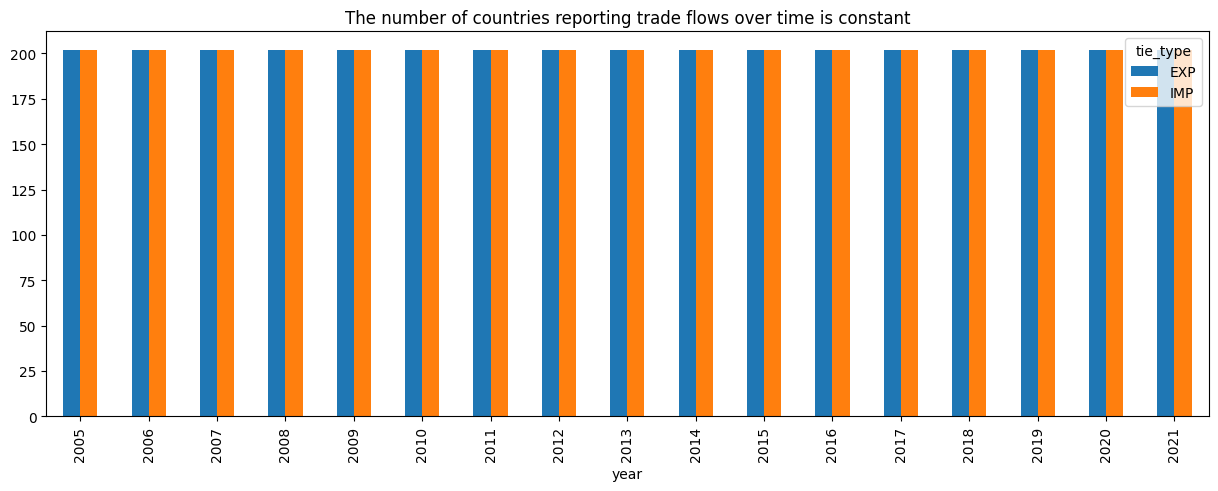

In [19]:
(batis_df.groupby(['year', 'tie_type'])['reporter'].nunique().reset_index()
         .pivot(index='year', columns='tie_type', values='reporter')
         .plot(kind='bar', stacked=False, figsize=(15, 5), 
               title='The number of countries reporting trade flows over time is constant'))

In [20]:
batis_df['self_reported'] = (batis_df['ego'] == batis_df['reporter'])

<Axes: title={'center': 'Discrepancy between self-reported and reported trade flows (top 4 discrepant countries)<br/>Positive = more reported EXP'}, xlabel='year'>

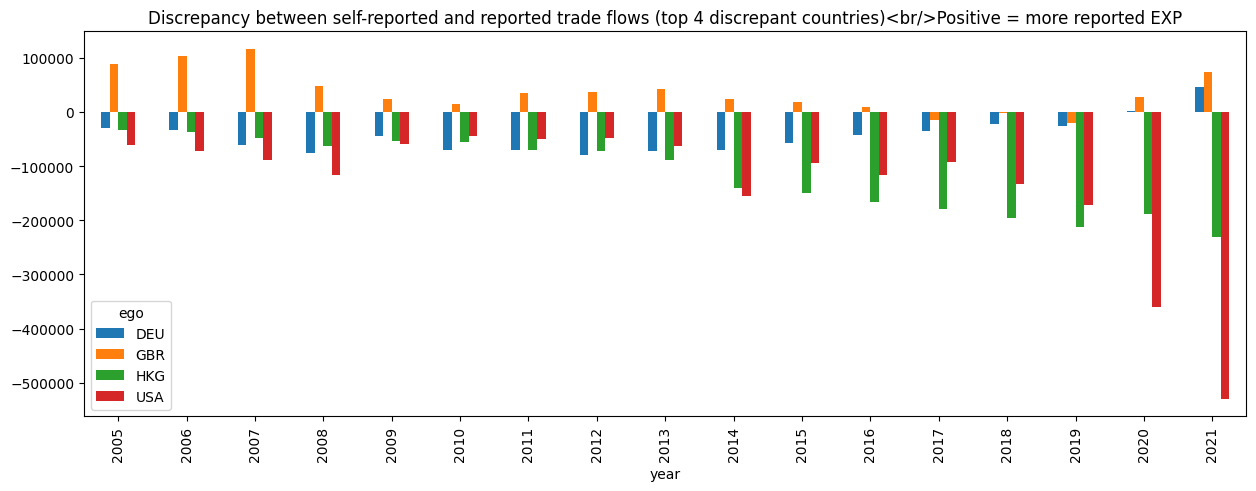

In [25]:
(batis_df.groupby(['year', 'ego', 'self_reported'])['weight'].sum()
         .groupby(['year', 'ego']).diff()
         .groupby(['year', 'ego']).last().reset_index()
         .query('ego == "USA" or ego == "DEU" or ego == "GBR" or ego == "HKG"')
        #  .groupby(['ego'])[['weight']].sum().abs()
         .pivot(index='year', columns='ego', values='weight')
         .plot(kind='bar', stacked=False, figsize=(15, 5),
               title='Discrepancy between self-reported and reported trade flows (top 4 discrepant countries)<br/>Positive = more reported EXP')
)#.sort_values(by='weight', ascending=False)